Here we will create balance classifiers to identify differences due to plant diet and country.

Make sure that the appropriate files are downloaded.  They can be obtained from the ftp link using the following commands

```bash
wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/deblur_125nt_no_blooms.biom

wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/ag_map_with_alpha.txt
```

Also load the correct environment.  That can be done with

```bash
conda env create -n balance-analysis -f env/gneiss-0.4.1.txt
```

In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
from patsy import dmatrix

%matplotlib inline
sns.set_style('ticks')

In [2]:
from gneiss.util import match_tips

table = load_table('deblur_125nt_no_blooms.biom')

obs_ids = table.ids(axis='observation')
taxonomies = [table.metadata(id=i, axis='observation')['taxonomy'] for i in obs_ids]
taxonomies = pd.DataFrame(taxonomies, index=obs_ids, 
                          columns=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species'])

# we will propagate the last annotation
def taxa_fix(x):
    x_ = x.copy()
    suffixes = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    for i, xi in enumerate(x_):
        if xi in suffixes:
            x_[i] = x_[i-1]
    return x_
taxa = taxonomies.apply(taxa_fix, axis=1)

metadata = pd.read_table('ag_map_with_alpha.txt', index_col=0)

/Users/mortonjt/miniconda3/envs/q2-gneiss/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from gneiss.util import match
def preprocess_plants(x):
    if x in ['Less than 5', '6 to 10']:
        return 'Less than 10'
    elif x == 'More than 30':
        return 'More than 30'
    else:
        return np.nan

def preprocess_country(x):
    if x == 'USA':
        return 'United States'
    elif x == 'United Kingdom':
        return x
    else:
        return np.nan

metadata['cleaned_plants'] = metadata.types_of_plants.apply(preprocess_plants)
metadata = metadata.dropna(subset=['cleaned_plants'])

# extract the healthy subset
#idx = np.logical_or(metadata.subset_healthy == 'True', metadata.subset_healthy == 'Yes')
#metadata = metadata.loc[idx]

# only focus on the United Kingdom and USA datasets
metadata['cleaned_country'] = metadata.country.apply(preprocess_country)
metadata = metadata.dropna(subset=['cleaned_country'])

We'll apply some very relaxed filters.  If an OTU only as 10 reads in the whole study, or only appears in 10 samples, it likely will not be informative.  So we'll filter out these samples. 

In [4]:
otu_filter = lambda val, id_, md: val.sum() > 50
var_filter = lambda val, id_, md: np.var(val) > 10
id_filter = lambda val, id_, md: id_ in metadata.index
sparse_filter = lambda val, id_, md: (val>0).sum() > 20

table = table.filter(id_filter, axis='sample')
table = table.filter(otu_filter, axis='observation')
table = table.filter(var_filter, axis='observation')
table = table.filter(sparse_filter, axis='observation')

table = pd.DataFrame(np.array(table.matrix_data.todense()).T, 
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))
table, metadata = match(table, metadata)

In the first step in creating a balance classifier, we'll want to first perform the clr transform on the data. 
To avoid issues with zeros, we'll appply a pseudocount.  

In [5]:
from skbio.stats.composition import clr, centralize

ctable = pd.DataFrame(clr(centralize(table+1)), index=table.index, columns=table.columns)

To just visualize the results, we'll perform Partial Least Squares with two components.
This will verify if there are clear patterns with respect to the types of plants and country analysis.

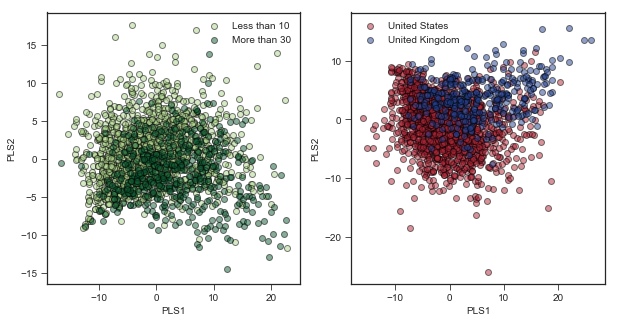

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression

plant_var = (metadata.cleaned_plants=='More than 30').values
country_var = (metadata.country=='USA').values

plants_pls = PLSRegression(n_components=2)
country_pls = PLSRegression(n_components=2)

plants_pls.fit(X=ctable.values, Y=plant_var)
country_pls.fit(X=ctable.values, Y=country_var)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

midx = metadata.cleaned_plants=='More than 30'
lidx = metadata.cleaned_plants=='Less than 10'
ax[0].scatter(plants_pls.x_scores_[lidx, 0], plants_pls.x_scores_[lidx, 1], 
              color='#b0d78e', label='Less than 10', edgecolor='k', marker='o', alpha=0.5)
ax[0].scatter(plants_pls.x_scores_[midx, 0], plants_pls.x_scores_[midx, 1], 
              color='#105d33', label='More than 30', edgecolor='k', marker='o', alpha=0.5)
ax[0].set_xlabel('PLS1')
ax[0].set_ylabel('PLS2')
ax[0].legend()

midx = metadata.cleaned_country=='United States'
lidx = metadata.cleaned_country=='United Kingdom'
ax[1].scatter(country_pls.x_scores_[midx, 0], country_pls.x_scores_[midx, 1], 
              color='#b22637', label='United States', edgecolor='k', marker='o', alpha=0.5)
ax[1].scatter(country_pls.x_scores_[lidx, 0], country_pls.x_scores_[lidx, 1], 
              color='#224191', label='United Kingdom', edgecolor='k', marker='o', alpha=0.5)
ax[1].set_xlabel('PLS1')
ax[1].set_ylabel('PLS2')
ax[1].legend()
plt.savefig('plants_country_pls_scatter.pdf')

To try to quantify all of the species that drive this difference, we will only look at one component of the partial least squares analysis.  This component will create a spectrum that scores all of the organisms.  In the types of plants analysis, this will rank all of the organisms if they are associated with "> 30" or "< 5" plants consumed per week.  In the country analysis, this will rank the organisms according to if they are associated with UK or USA samples.

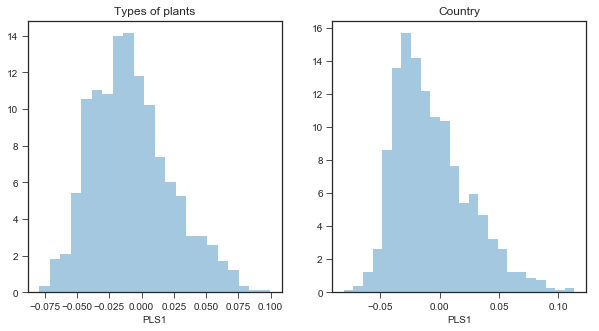

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plants_pls = PLSRegression(n_components=1)
country_pls = PLSRegression(n_components=1)

plants_pls.fit(X=ctable.values, Y=plant_var)
country_pls.fit(X=ctable.values, Y=country_var)

plants_spectrum = pd.DataFrame(plants_pls.x_weights_, index=ctable.columns, columns=['PLS1'])
country_spectrum = pd.DataFrame(country_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

sns.distplot(plants_spectrum.PLS1, ax=ax[0], norm_hist=True, kde=False)
sns.distplot(country_spectrum.PLS1, ax=ax[1], norm_hist=True, kde=False)
ax[0].set_title('Types of plants')
ax[1].set_title('Country')

From simulations, we have observed that components that don't fall into the numerator or the denominator of the desired balance follow roughly a Gaussian distribution.  We will take advantage of this and fit Gaussian mixture models.  Specifically, we will fit 3 Gaussians, one for the features in the denominator, one for the features in the numerator, and another one for features that don't fall in the numerator or denominator.  To evaluate how well these Gaussian fit, we'll fit those 3 mixtures on the histograms and visualize them.

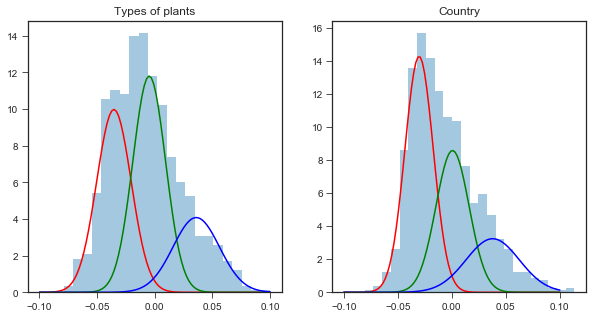

In [8]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plants_mixture = GaussianMixture(n_components=3, random_state=0)
plants_mixture.fit(X=plants_spectrum.values)

country_mixture = GaussianMixture(n_components=3, random_state=0)
country_mixture.fit(X=country_spectrum.values)

plant_m = np.ravel(plants_mixture.means_)
plant_s = np.ravel(np.sqrt(plants_mixture.covariances_)) 
plant_w = np.ravel(plants_mixture.weights_)

country_m = np.ravel(country_mixture.means_)
country_s = np.ravel(np.sqrt(country_mixture.covariances_)) 
country_w = np.ravel(country_mixture.weights_)

x = np.linspace(-0.1, 0.1, 100)
sns.distplot(plants_spectrum, norm_hist=True, kde=False, ax=ax[0])
ax[0].plot(x, plant_w[0]*norm.pdf(x, plant_m[0], plant_s[0]), '-r')
ax[0].plot(x, plant_w[1]*norm.pdf(x, plant_m[1], plant_s[1]), '-g')
ax[0].plot(x, plant_w[2]*norm.pdf(x, plant_m[2], plant_s[2]), '-b')

sns.distplot(country_spectrum, norm_hist=True, kde=False, ax=ax[1])
ax[1].plot(x, country_w[0]*norm.pdf(x, country_m[0], country_s[0]), '-r')
ax[1].plot(x, country_w[1]*norm.pdf(x, country_m[1], country_s[1]), '-g')
ax[1].plot(x, country_w[2]*norm.pdf(x, country_m[2], country_s[2]), '-b')
ax[0].set_title('Types of plants')
ax[1].set_title('Country')
plt.savefig('plants_country_mixtures.pdf')

Once the Gaussian Mixture Models are fitted, we can use the intersections between them to set thresholds for which features should be assigned to the numerator and the denominator.  For example in the Country analysis, any features that fall below the intersection between the blue and green Gaussians will be assigned to the denominator.  Furthermore, the features that fall above the blue and red Gaussians will be assigned to the numerator.

Judging from the fits above it looks like the Gaussian Mixture Models are relatively sane.  Now we will actually solve for those thresholds.  Because we have already fitted the Gaussians, solving for the thresholds will be relatively simple. The following code will be able to do this.

In [9]:
def solve(w1, w2, m1, m2, std1, std2):
    r""" Solves for the intersection between Gaussians.

    Parameters
    ----------
    w1: float
        The weight of the first distribution
    w2: float
        The weight of the second distribution
    m1: float
        The mean of the first distribution
    m2: float
        The mean of the second distribution
    std1: float
        The standard deviation of the first distribution
    std2: float
        The standard deviation of the second distribution
    
    Returns
    -------
    np.array :
        List of intersection points
    """
    # from stackoverflow
    # https://stackoverflow.com/a/22579904/1167475
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log((w1/w2) * np.sqrt(std2/std1))
    return np.roots([a,b,c])

def reorder(mid, m):
    """ Reorders indexes so that the means are in increasing order. """
    lookup = {0: [1, 2], 1: [0, 2], 2: [0, 1]}
    l, r = lookup[mid]
    if m[l] > m[r]:
        l, r = r, l
    return l, mid, r

def balance_thresholds(spectrum):
    """ Calculates thresholds for the balances.
    
    Parameters
    ----------
    spectrum : np.array
        The axis of interest.  This will rank all of the features for the balance selection.
    """
    gmod = GaussianMixture(n_components=3)
    gmod.fit(X=spectrum)
    m = gmod.means_
    std = np.sqrt(np.ravel(gmod.covariances_))
    w = gmod.weights_

    # first identify the distribution closest to zero
    mid = np.argmin(np.abs(m))

    # solve for intersections closest to zero
    l, mid, r = reorder(mid, m)
    lsol = solve(w[mid], w[l], m[mid], m[l], std[mid], std[l])
    rsol = solve(w[mid], w[r], m[mid], m[r], std[mid], std[r])

    lsol = lsol[np.argmin(np.abs(lsol))]
    rsol = rsol[np.argmin(np.abs(rsol))]    
    return lsol, rsol

Now let's actually calculate the thresholds and calculate the balances.  Note that we have included normalization constants, so that the scales in the PLS plots above are comparable to the scale of the balances plots below.

In [10]:
left_plant_threshold, right_plant_threshold = balance_thresholds(plants_spectrum.values)
left_country_threshold, right_country_threshold = balance_thresholds(country_spectrum.values)

plant_denom = plants_spectrum.loc[plants_spectrum.PLS1 < left_plant_threshold]
plant_num = plants_spectrum.loc[plants_spectrum.PLS1 > right_plant_threshold]

country_denom = country_spectrum.loc[country_spectrum.PLS1 < left_country_threshold]
country_num = country_spectrum.loc[country_spectrum.PLS1 > right_country_threshold]

r, s = plant_num.shape[0], plant_denom.shape[0] 
plant_balance = (np.log(table.loc[:, plant_num.index] + 1).mean(axis=1) - 
                 np.log(table.loc[:, plant_denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

r, s = country_num.shape[0], country_denom.shape[0] 
country_balance = (np.log(table.loc[:, country_num.index] + 1).mean(axis=1) - 
                   np.log(table.loc[:, country_denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

From here, we can plot the boxplots of these balances across all of the samples.  This will give us an idea about the classification accuracy of the balances that we have picked.

/Users/mortonjt/miniconda3/envs/q2-gneiss/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


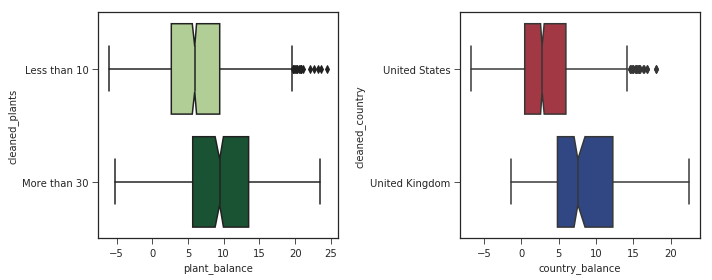

In [11]:
from gneiss.plot import balance_boxplot, balance_barplots
from matplotlib import rc

sns.set_style('white')
sns.set_style('ticks')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

balance_df = pd.DataFrame({'plant_balance': plant_balance,
                           'country_balance': country_balance})

data = pd.merge(metadata, balance_df, left_index=True, right_index=True)

sns.boxplot(y='cleaned_plants', x='plant_balance', data=data, notch=True, bootstrap=1000,
            palette={'Less than 10': '#b0d78e', 'More than 30': '#105d33'}, orient='h',
            order=['Less than 10', 'More than 30'], ax=ax[0])

sns.boxplot(y='cleaned_country', x='country_balance', data=data, notch=True, bootstrap=1000,
            palette={'United States': '#b22637', 'United Kingdom': '#224191'}, orient='h',
            order=['United States', 'United Kingdom'], ax=ax[1])

plt.tight_layout()
plt.savefig('plants_country_boxplots.pdf')

We can also plot histograms to evaluate the distributions.

/Users/mortonjt/miniconda3/envs/q2-gneiss/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


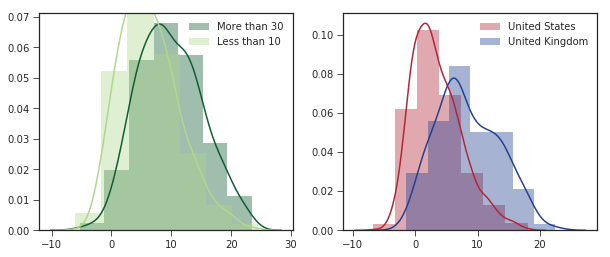

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(plant_balance[metadata.cleaned_plants=='More than 30'], 
             label='More than 30', color='#105d33', bins=7, ax=ax[0])
sns.distplot(plant_balance[metadata.cleaned_plants=='Less than 10'], 
             label='Less than 10', color='#b0d78e', bins=7, ax=ax[0])
ax[0].legend()

sns.distplot(country_balance[metadata.cleaned_country=='United States'], 
             label='United States', color='#b22637', bins=7, ax=ax[1])
sns.distplot(country_balance[metadata.cleaned_country=='United Kingdom'], 
             label='United Kingdom', color='#224191', bins=7, ax=ax[1])
ax[1].legend() 
plt.savefig('plants_country_balance_histograms.pdf')

Let's generate some ROC curves to evaluation the classification accuracy.  We don't expect the classification accuracy to be great, since this is a linear classifier.  But it can clearly define taxa that are associated with the sample environments.

/Users/mortonjt/miniconda3/envs/q2-gneiss/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


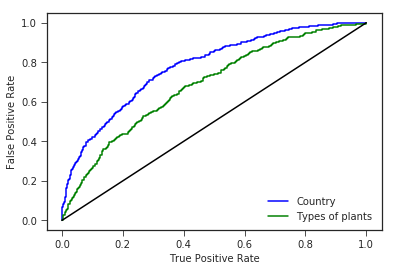

In [13]:
from sklearn.metrics import roc_curve
plant_fpr, plant_tpr, plant_thresholds = roc_curve(y_true=1-plant_var.astype(int), 
                                                   y_score=plant_balance)
country_fpr, country_tpr, country_thresholds = roc_curve(y_true=country_var.astype(int), 
                                                         y_score=country_balance)

plt.plot(country_tpr, country_fpr, label='Country', c='blue')
plt.plot(plant_tpr, plant_fpr, label='Types of plants', c='green')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('plants_country_roc_curves.pdf')

Now let's calculate the Area under the curve (AUC).  This is basically the classification accuracy.

In [14]:
from sklearn.metrics import auc
print('Country AUC:\t\t', auc(country_tpr, country_fpr))
print('Types of Plants AUC:\t', auc(plant_tpr, plant_fpr))

Country AUC:		 0.777795539641
Types of Plants AUC:	 0.683866821239


Just to access the significance of this separation, let's run ANOVA to get F-statistics and pvalues.

In [15]:
from scipy.stats import f_oneway
plant_f, plant_p = f_oneway(plant_balance.loc[metadata.cleaned_plants=='More than 30'],
                            plant_balance.loc[metadata.cleaned_plants=='Less than 10'])

country_f, country_p = f_oneway(country_balance.loc[metadata.cleaned_country=='United States'],
                                country_balance.loc[metadata.cleaned_country=='United Kingdom'])
print('Types of plants\t -- F-statistic: %f \t p-value: \t %E' % (plant_f, plant_p))
print('Country \t -- F-statistic: %f \t p-value: \t %E' % (country_f, country_p))

Types of plants	 -- F-statistic: 173.880293 	 p-value: 	 4.241059E-38
Country 	 -- F-statistic: 393.524235 	 p-value: 	 6.220848E-80


It looks like we are seeing a real, clear signal here in both the country and types of plants categories.

Let's now try to interpret what the balances mean.  We'll generate taxonomy plots at the family level to interpret the numerator and denominator of both of these balances.  But to that, we need to employ some pandas magic to clean up the data prior to plotting.

In [16]:
level = 'sequence'

# normalize everything to add to 1
ptable = table.apply(lambda x: (x+1) / (x+1).sum(), axis=1) + 1e-6

# extract numerator and denominator proportions separately
# we'll only focus on top 5 hits
num_filtered = plants_spectrum.sort_values(by='PLS1').tail(5).index
denom_filtered = plants_spectrum.sort_values(by='PLS1').head(5).index

num_props = ptable[num_filtered]
denom_props = ptable[denom_filtered]

num_collapsed = ptable[num_filtered]
denom_collapsed = ptable[denom_filtered]

# merge together metadata and sequences
num_data_ = pd.merge(metadata, num_collapsed, left_index=True, right_index=True)
denom_data_ = pd.merge(metadata, denom_collapsed, left_index=True, right_index=True)

# merge the data frame, so that all of the proportions are in their own separate column
num_data = pd.melt(num_data_, id_vars=['cleaned_plants'], 
                   value_vars=list(num_collapsed.columns), 
                   value_name='proportion', var_name=level)
num_data['part'] = 'numerator'
denom_data = pd.melt(denom_data_, id_vars=['cleaned_plants'], 
                     value_vars=list(denom_collapsed.columns), 
                     value_name='proportion', var_name=level)
denom_data['part'] = 'denominator'
data = pd.concat((num_data, denom_data))

Now let's create the mean proportion plots.  Here we will only focus types of plants.  

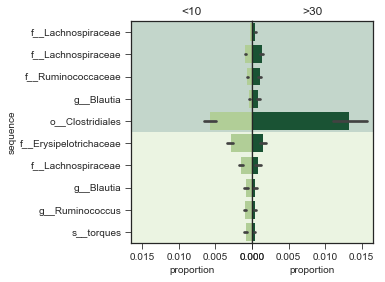

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style('ticks')
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
ax1, ax2 = ax

num_taxa = taxa.loc[num_collapsed.columns, 'species']
denom_taxa = taxa.loc[denom_collapsed.columns, 'species']

num_color   = '#105d33' # >30
denom_color = '#b0d78e' # <5

less_df = data.loc[data['cleaned_plants']=='Less than 10'].dropna()
sns.barplot(x='proportion',  
            y=level, 
            data=less_df,
            color=denom_color,
            order=list(num_taxa.index) + list(denom_taxa.index),
            ax=ax1)
more_df = data.loc[data['cleaned_plants']=='More than 30'].dropna()
sns.barplot(x='proportion',  
            y=level, 
            data=more_df,
            color=num_color,
            order=list(num_taxa.index) + list(denom_taxa.index),
            ax=ax2)

ax1.set(yticklabels=sorted(num_taxa) + sorted(denom_taxa), title='<10')
ax2.set(yticklabels=[], ylabel='', yticks=[], title='>30')

max_xlim = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
min_xlim = max(ax1.get_xlim()[0], ax2.get_xlim()[0])

max_ylim, min_ylim = ax1.get_ylim()

xlim = ([min_xlim, max_xlim])
ax1.set_xlim(max_xlim, min_xlim)
ax2.set_xlim(min_xlim, max_xlim)
ax1.set_position([0.2, 0.125, 0.3, 0.75])
ax2.set_position([0.5, 0.125, 0.3, 0.75])


num_h = num_collapsed.shape[1]
denom_h = denom_collapsed.shape[1]

space = (max_ylim - min_ylim) / (num_h + denom_h)
ymid = (max_ylim - min_ylim) * num_h /  (num_h + denom_h) - 0.5*space

ax1.axhspan(min_ylim, ymid, facecolor=num_color, zorder=0, alpha=0.25)
ax1.axhspan(ymid, max_ylim, facecolor=denom_color, zorder=0, alpha=0.25)

ax2.axhspan(min_ylim, ymid, facecolor=num_color, zorder=0, alpha=0.25)
ax2.axhspan(ymid, max_ylim, facecolor=denom_color, zorder=0, alpha=0.25)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plant_taxonomy_proportions.svg', bbox_inches = 'tight')

Let's do the same thing for the country analysis.

In [18]:
level = 'sequence'

# normalize everything to add to 1
ptable = table.apply(lambda x: (x+1) / (x+1).sum(), axis=1) + 1e-6

# extract numerator and denominator proportions separately
# we'll only focus on top 5 hits
num_filtered = country_spectrum.sort_values(by='PLS1').tail(5).index
denom_filtered = country_spectrum.sort_values(by='PLS1').head(5).index

num_props = ptable[num_filtered]
denom_props = ptable[denom_filtered]

num_collapsed = ptable[num_filtered]
denom_collapsed = ptable[denom_filtered]

# merge together metadata and sequences
num_data_ = pd.merge(metadata, num_collapsed, left_index=True, right_index=True)
denom_data_ = pd.merge(metadata, denom_collapsed, left_index=True, right_index=True)

# merge the data frame, so that all of the proportions are in their own separate column
num_data = pd.melt(num_data_, id_vars=['cleaned_country'], 
                   value_vars=list(num_collapsed.columns), 
                   value_name='proportion', var_name=level)
num_data['part'] = 'numerator'
denom_data = pd.melt(denom_data_, id_vars=['cleaned_country'], 
                     value_vars=list(denom_collapsed.columns), 
                     value_name='proportion', var_name=level)
denom_data['part'] = 'denominator'
data = pd.concat((num_data, denom_data))

Like before, let's plot the mean proportions.

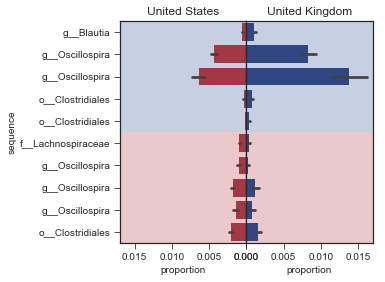

In [19]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style('ticks')
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
ax1, ax2 = ax

num_taxa = taxa.loc[num_collapsed.columns, 'species']
denom_taxa = taxa.loc[denom_collapsed.columns, 'species']

num_color   = '#224191' # >30
denom_color = '#b22637' # <5

usa_df = data.loc[data['cleaned_country']=='United States'].dropna()
sns.barplot(x='proportion',  
            y=level, 
            data=usa_df,
            color=denom_color,
            order=list(num_taxa.index) + list(denom_taxa.index),
            ax=ax1)
uk_df = data.loc[data['cleaned_country']=='United Kingdom'].dropna()
sns.barplot(x='proportion',  
            y=level, 
            data=uk_df,
            color=num_color,
            order=list(num_taxa.index) + list(denom_taxa.index),
            ax=ax2)

ax1.set(yticklabels=sorted(num_taxa) + sorted(denom_taxa), title='United States')
ax2.set(yticklabels=[], ylabel='', yticks=[], title='United Kingdom')

max_xlim = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
min_xlim = max(ax1.get_xlim()[0], ax2.get_xlim()[0])

max_ylim, min_ylim = ax1.get_ylim()

xlim = ([min_xlim, max_xlim])
ax1.set_xlim(max_xlim, min_xlim)
ax2.set_xlim(min_xlim, max_xlim)
ax1.set_position([0.2, 0.125, 0.3, 0.75])
ax2.set_position([0.5, 0.125, 0.3, 0.75])


num_h = num_collapsed.shape[1]
denom_h = denom_collapsed.shape[1]

space = (max_ylim - min_ylim) / (num_h + denom_h)
ymid = (max_ylim - min_ylim) * num_h /  (num_h + denom_h) - 0.5*space

ax1.axhspan(min_ylim, ymid, facecolor=num_color, zorder=0, alpha=0.25)
ax1.axhspan(ymid, max_ylim, facecolor=denom_color, zorder=0, alpha=0.25)

ax2.axhspan(min_ylim, ymid, facecolor=num_color, zorder=0, alpha=0.25)
ax2.axhspan(ymid, max_ylim, facecolor=denom_color, zorder=0, alpha=0.25)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('country_taxonomy_proportions.svg', bbox_inches = 'tight')

Finally, let's package the results into csv files.

In [20]:
plant_num_data = pd.merge(plant_num, taxonomies.loc[plant_num.index], left_index=True, right_index=True)
plant_num_data['part'] = 'numerator'
plant_denom_data = pd.merge(plant_denom, taxonomies.loc[plant_denom.index], left_index=True, right_index=True)
plant_denom_data['part'] = 'denominator'

plant_balance_summary = pd.concat((plant_num_data, plant_denom_data))
plant_balance_summary.to_csv('plant_balance_summary.csv')

country_num_data = pd.merge(country_num, taxonomies.loc[country_num.index], left_index=True, right_index=True)
country_num_data['part'] = 'numerator'
country_denom_data = pd.merge(country_denom, taxonomies.loc[country_denom.index], left_index=True, right_index=True)
country_denom_data['part'] = 'denominator'

country_balance_summary = pd.concat((country_num_data, country_denom_data))
country_balance_summary.to_csv('country_balance_summary.csv')